## Import

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Load Data / Normalize

In [4]:
# load data and normalize it
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

In [32]:
# Create train and test datasets

x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)
y train/test shapes: (80000, 200, 2) (20000, 200, 2)


In [33]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
 507/2000 ━━━━━━━━━━━━━━━━━━━━ 4:46 192ms/step - loss: 3.4866

KeyboardInterrupt: 

In [ ]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

## Train / Test Splits

x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

In [34]:
combined_data = np.concatenate([background, bbh, sglf], axis=0)
combined_labels = np.concatenate([
    np.zeros(len(background)),  # Label 0: background
    np.zeros(len(bbh)),         # Label 0: BBH (non-anomalous)
    np.ones(len(sglf))          # Label 1: SGLF (anomalous)
])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=42
)

##3 thing


## Autoencoder

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf

# Step 1: Split datasets
# Background data for autoencoder training
X_autoencoder = background  # Use only background data
X_bbh_sglf = np.concatenate([bbh, sglf], axis=0)
y_bbh_sglf = np.concatenate([
    np.zeros(len(bbh)),  # BBH (non-anomalous but different)
    np.ones(len(sglf))       # SGLF (anomalous)
])

# Step 2: Train-test split for the BBH and SGLF data
X_bbh_sglf_train, X_bbh_sglf_test, y_bbh_sglf_train, y_bbh_sglf_test = train_test_split(
    X_bbh_sglf, y_bbh_sglf, test_size=0.2, random_state=42
)

# Step 3: Define autoencoder
def create_autoencoder(input_shape, latent_dim=16):
    inputs = tf.keras.Input(shape=input_shape)
    # Encoder
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name="latent_space")(x)
    
    # Decoder
    x = layers.Dense((input_shape[0] // 4) * 64, activation='relu')(latent)
    x = layers.Reshape((input_shape[0] // 4, 64))(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoded = layers.Conv1D(input_shape[-1], kernel_size=3, activation='sigmoid', padding='same')(x)
    
    # Autoencoder
    autoencoder = tf.keras.Model(inputs, decoded)
    encoder = tf.keras.Model(inputs, latent)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Step 4: Train autoencoder on background data
autoencoder, encoder = create_autoencoder(X_autoencoder.shape[1:], latent_dim=16)
autoencoder.fit(
    X_autoencoder, X_autoencoder,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

latent_background = encoder.predict(X_autoencoder)  # Latent space for background
latent_bbh_sglf = encoder.predict(X_bbh_sglf_train)  # Latent space for BBH and SGLF

# Combine all latent representations for k-means
latent_representations = np.concatenate([latent_background, latent_bbh_sglf], axis=0)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 1.0072 - val_loss: 1.0005
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 1.0005 - val_loss: 1.0005
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


In [52]:
# Step 6: k-Means clustering
from sklearn.cluster import KMeans
latent_representations_all = np.concatenate([latent_background, latent_bbh_sglf], axis=0)

# Perform k-means clustering on all latent representations
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels_all = kmeans.fit_predict(latent_representations_all)

# Step 7: Assign cluster labels to BBH and SGLF
# Extract cluster labels corresponding to BBH and SGLF data
cluster_labels_bbh_sglf = cluster_labels_all[len(latent_background):]

# Step 7.1: Calculate cluster distances for BBH and SGLF
# Use the fitted k-means model to compute distances to centroids
cluster_distances_bbh_sglf = kmeans.transform(latent_bbh_sglf)


X_features_train = np.column_stack([
    reconstruction_errors_train,       # Reconstruction errors
    cluster_distances_bbh_sglf,        # Distances to cluster centroids
    cluster_labels_bbh_sglf            # Cluster labels
])


NameError: name 'reconstruction_errors_train' is not defined

In [45]:
from sklearn.neural_network import MLPRegressor

# Initialize the neural network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)

# Train the neural network
nn_model.fit(X_features_train, y_bbh_sglf_train)


# Generate test features
reconstruction_errors_test = np.mean(
    np.square(autoencoder.predict(X_bbh_sglf_test) - X_bbh_sglf_test),
    axis=(1, 2)
)
latent_representations_test = encoder.predict(X_bbh_sglf_test)
cluster_distances_test = kmeans.transform(latent_representations_test)
cluster_labels_test = kmeans.predict(latent_representations_test)

# Combine test features
X_features_test = np.column_stack([
    reconstruction_errors_test,  # Reconstruction errors
    cluster_distances_test,      # Cluster distances
    cluster_labels_test          # Cluster labels
])

# Predict anomaly probabilities
y_pred = nn_model.predict(X_features_test)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [46]:
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, recall_score

# Calculate metrics
mse = mean_squared_error(y_bbh_sglf_test, y_pred)
roc_auc = roc_auc_score(y_bbh_sglf_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Mean Squared Error: 0.3070
ROC-AUC: 0.4894


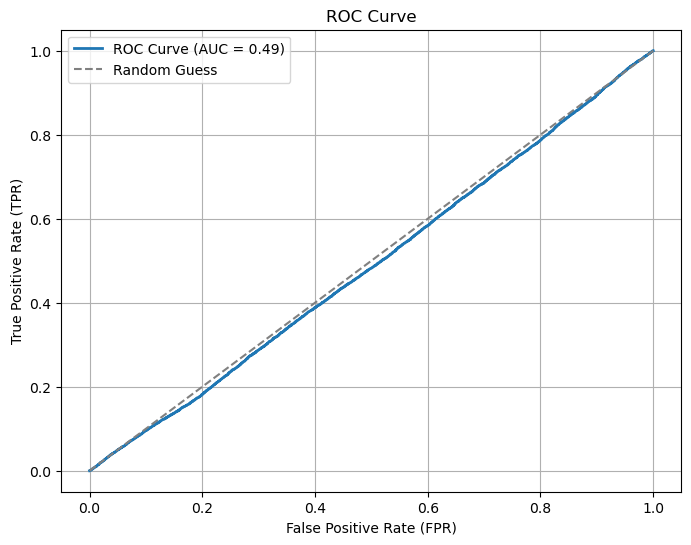

In [47]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_bbh_sglf_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# Sample 30% from background, 30% from SGLF, and 40% from BBH
n_samples = 1000  # Total number of samples in the new dataset
n_background = int(0.3 * n_samples)
n_sglf = int(0.3 * n_samples)
n_bbh = n_samples - n_background - n_sglf

# Randomly sample
background_sample = background[np.random.choice(len(background), n_background, replace=False)]
sglf_sample = sglf[np.random.choice(len(sglf), n_sglf, replace=False)]
bbh_sample = bbh[np.random.choice(len(bbh), n_bbh, replace=False)]

# Concatenate the datasets
new_data = np.concatenate([background_sample, bbh_sample, sglf_sample], axis=0)
new_labels = np.concatenate([
    np.zeros(len(background_sample)),  # Non-anomalous: Background
    np.zeros(len(bbh_sample)),        # Non-anomalous: BBH
    np.ones(len(sglf_sample))         # Anomalous: SGLF
])


In [50]:
print(f"Length of new_labels: {len(new_labels)}")
print(f"Length of y_pred: {len(y_pred)}")

# Match sizes if necessary
if len(y_pred) != len(new_labels):
    y_pred = y_pred[:len(new_labels)]

# Recalculate binary predictions
y_binary_pred = (y_pred >= 0.7).astype(int)

# Calculate metrics
precision = precision_score(new_labels, y_binary_pred)
recall = recall_score(new_labels, y_binary_pred)
roc_auc = roc_auc_score(new_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Length of new_labels: 1000
Length of y_pred: 40000
Precision: 0.28
Recall: 0.45
ROC-AUC: 0.47


## Kmeans

In [5]:
from sklearn.cluster import KMeans

# Extract latent features
latent_features = encoder.predict(X_train)

# Apply K-Means
n_clusters = 2  # One for normal, one for anomalies
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(latent_features)

# Compute cluster distances
cluster_distances = kmeans.transform(latent_features)  # Distance to cluster centers


NameError: name 'encoder' is not defined

## Neural Network

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from tensorflow.keras import layers
import tensorflow as tf

# Step 1: Autoencoder Training on Background Data
# Train autoencoder only on background data to capture "normal" behavior
X_autoencoder = background  # Use only background data

def create_autoencoder(input_shape, latent_dim=16):
    inputs = tf.keras.Input(shape=input_shape)
    # Encoder
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name="latent_space")(x)
    # Decoder
    x = layers.Dense((input_shape[0] // 4) * 64, activation='relu')(latent)
    x = layers.Reshape((input_shape[0] // 4, 64))(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    decoded = layers.Conv1D(input_shape[-1], kernel_size=3, activation='sigmoid', padding='same')(x)
    autoencoder = tf.keras.Model(inputs, decoded)
    encoder = tf.keras.Model(inputs, latent)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Create and train autoencoder
autoencoder, encoder = create_autoencoder(X_autoencoder.shape[1:], latent_dim=16)
autoencoder.fit(
    X_autoencoder, X_autoencoder,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Step 2: Calculate Reconstruction Errors
# Reconstruction errors for all datasets
reconstruction_errors_background = np.mean(
    np.square(autoencoder.predict(X_autoencoder) - X_autoencoder), axis=(1, 2)
)
reconstruction_errors_bbh = np.mean(
    np.square(autoencoder.predict(bbh) - bbh), axis=(1, 2)
)
reconstruction_errors_sglf = np.mean(
    np.square(autoencoder.predict(sglf) - sglf), axis=(1, 2)
)

# Step 3: Generate Latent Representations
latent_background = encoder.predict(X_autoencoder)  # Background latent space
latent_bbh = encoder.predict(bbh)  # BBH latent space
latent_sglf = encoder.predict(sglf)  # SGLF latent space

# Step 4: Combine Datasets for Clustering
# Combine latent representations and reconstruction errors
latent_representations_all = np.concatenate([latent_background, latent_bbh, latent_sglf], axis=0)

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels_all = kmeans.fit_predict(latent_representations_all)
cluster_distances_all = kmeans.transform(latent_representations_all)

# Step 5: Create Combined Dataset with Labels
# Labels: 0 for background and BBH, 1 for SGLF
combined_data = np.concatenate([background, bbh, sglf], axis=0)
combined_labels = np.concatenate([
    np.zeros(len(background)),  # Background (non-anomalous)
    np.zeros(len(bbh)),         # BBH (non-anomalous)
    np.ones(len(sglf))          # SGLF (anomalous)
])

# Reconstruction errors for combined dataset
reconstruction_errors_all = np.concatenate([
    reconstruction_errors_background,
    reconstruction_errors_bbh,
    reconstruction_errors_sglf
])

# Combine features
X_features_all = np.column_stack([
    reconstruction_errors_all,  # Reconstruction errors
    cluster_distances_all,      # Distances to cluster centroids
    cluster_labels_all          # Cluster labels
])



2025-01-12 22:35:36.972452: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 1.0065 - val_loss: 1.0005
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 1.0005 - val_loss: 1.0005
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import numpy as np

# Step 6: Train-Test Split with Flattening
# Flatten the combined data to ensure it is 2D
combined_data_flattened = combined_data.reshape(combined_data.shape[0], -1)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_data_flattened, combined_labels, test_size=0.2, random_state=42, stratify=combined_labels
)

# Step 7: Train Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)

# Fit the model on training data
nn_model.fit(X_train, y_train)

# Step 8: Evaluate on Test Data
# Predict anomaly probabilities
y_pred = nn_model.predict(X_test)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")  # Should be (n_samples, n_features)
print(f"y_train shape: {y_train.shape}")  # Should be (n_samples,)


X_train shape: (240000, 400)
y_train shape: (240000,)


In [7]:
from sklearn.metrics import confusion_matrix

# Threshold for anomaly classification
threshold = 0.7
y_binary_pred = (y_pred >= threshold).astype(int)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_binary_pred).ravel()

# TPR and TNR
tpr = tp / (tp + fn)  # True Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"True Negative Rate (TNR): {tnr:.2f}")


True Positive Rate (TPR): 0.87
True Negative Rate (TNR): 0.96


In [8]:
y_pred

array([-0.06367015, -0.0068785 ,  0.02450318, ..., -0.02216945,
       -0.00103558,  0.96035696])

In [16]:
# Compute reconstruction errors
reconstructed_data = autoencoder.predict(X_train)
reconstruction_errors = np.mean((reconstructed_data - X_train) ** 2, axis=(1, 2))

# Combine features for anomaly detection
features = np.stack([reconstruction_errors, cluster_distances.min(axis=1)], axis=1)

# Neural network for anomaly probability
nn_model = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output: anomaly probability
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
nn_model.fit(features, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate on the test set
latent_test_features = encoder.predict(X_test)
test_reconstructed = autoencoder.predict(X_test)
test_reconstruction_errors = np.mean((test_reconstructed - X_test) ** 2, axis=(1, 2))
test_cluster_distances = kmeans.transform(latent_test_features).min(axis=1)

test_features = np.stack([test_reconstruction_errors, test_cluster_distances], axis=1)
test_predictions = nn_model.predict(test_features)

# Print anomaly probabilities
print("Anomaly probabilities (first 10):", test_predictions[:10].flatten())


2025-01-12 03:05:14.236461: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 18 configs for triton_gemm_dot.69 on a single thread.


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Epoch 1/20


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-12 03:05:36.071569: W external/local_xla/xla/service/gpu/triton_autotuner.cc:660] Compiling 4 configs for 2 fusions on a single thread.


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.6553 - loss: 0.6358 - val_accuracy: 0.6679 - val_loss: 0.6268
Epoch 2/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.6664 - loss: 0.6276 - val_accuracy: 0.6679 - val_loss: 0.6249
Epoch 3/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6652 - loss: 0.6260 - val_accuracy: 0.6679 - val_loss: 0.6267
Epoch 4/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6678 - loss: 0.6227 - val_accuracy: 0.6679 - val_loss: 0.6193
Epoch 5/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6679 - loss: 0.6173 - val_accuracy: 0.6668 - val_loss: 0.6154
Epoch 6/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6661 - loss: 0.6137 - val_accuracy: 0.6678 - val_loss: 0.6124
Epoch 7/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6649 - loss: 0.6113 - val_accuracy: 0.6663 - val_loss: 0.6076
Epoch 8/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6648 - loss: 0.6064 - val_a

In [ ]:
test_predictions


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step


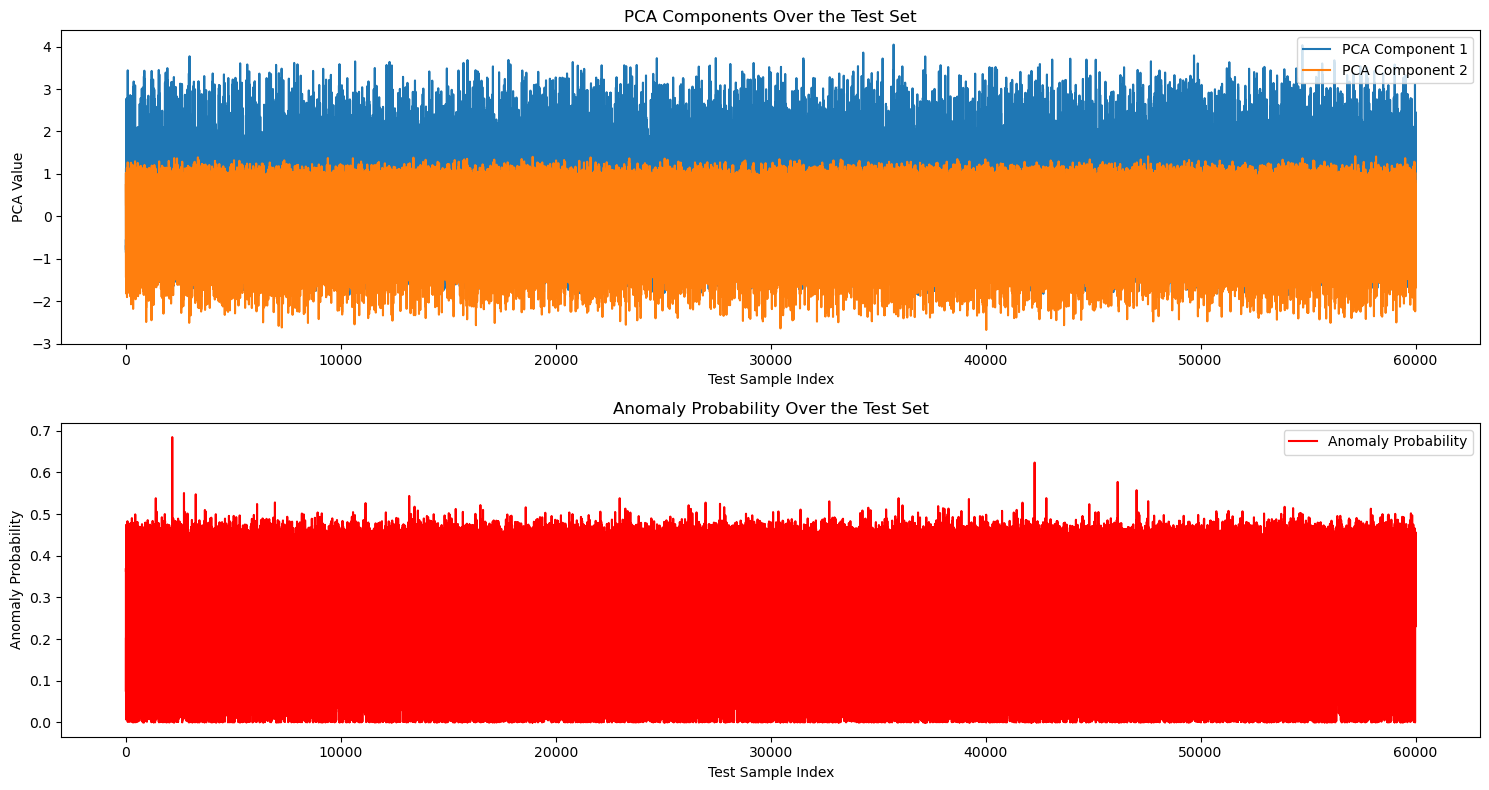

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Reduce Latent Features to 2D using PCA
latent_test_features = encoder.predict(X_test)  # Extract latent features from encoder
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_test_features)

# Step 2: Plot PCA Components and Anomaly Probabilities
def plot_pca_and_anomalies(pca_components, probabilities):
    plt.figure(figsize=(15, 8))

    # Plot PCA Components
    plt.subplot(2, 1, 1)
    plt.plot(pca_components[:, 0], label="PCA Component 1")
    plt.plot(pca_components[:, 1], label="PCA Component 2")
    plt.title("PCA Components Over the Test Set")
    plt.xlabel("Test Sample Index")
    plt.ylabel("PCA Value")
    plt.legend()

    # Plot Anomaly Probabilities
    plt.subplot(2, 1, 2)
    plt.plot(probabilities, 'r-', label="Anomaly Probability")
    plt.title("Anomaly Probability Over the Test Set")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Anomaly Probability")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize
plot_pca_and_anomalies(latent_2d, test_predictions.flatten())


In [26]:
def calculate_anomaly_percentages(data, model, threshold):
    # Extract latent features
    latent_features = encoder.predict(data)
    
    # Compute reconstruction errors
    reconstructed_data = autoencoder.predict(data)
    reconstruction_errors = np.mean((reconstructed_data - data) ** 2, axis=(1, 2))
    
    # Compute cluster distances
    cluster_distances = kmeans.transform(latent_features).min(axis=1)
    
    # Combine features
    features = np.stack([reconstruction_errors, cluster_distances], axis=1)
    
    # Predict anomaly probabilities
    anomaly_probabilities = model.predict(features).flatten()
    
    # Flag samples as anomalous based on threshold
    flagged_anomalous = anomaly_probabilities > threshold
    percentage_anomalous = np.sum(flagged_anomalous) / len(data) * 100
    
    return percentage_anomalous, flagged_anomalous

# Define threshold for anomaly probability
anomaly_threshold = 0.5  # Adjust based on your use case

# Calculate anomaly percentages for each dataset
background_anomalous_percentage, background_flags = calculate_anomaly_percentages(background, nn_model, anomaly_threshold)
bbh_anomalous_percentage, bbh_flags = calculate_anomaly_percentages(bbh, nn_model, anomaly_threshold)
sglf_anomalous_percentage, sglf_flags = calculate_anomaly_percentages(sglf, nn_model, anomaly_threshold)

# Print results
print(f"Percentage of Background flagged as anomalous: {background_anomalous_percentage:.2f}%")
print(f"Percentage of BBH flagged as anomalous: {bbh_anomalous_percentage:.2f}%")
print(f"Percentage of SGLF flagged as anomalous: {sglf_anomalous_percentage:.2f}%")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 790us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 793us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 723us/step
Percentage of Background flagged as anomalous: 0.17%
Percentage of BBH flagged as anomalous: 0.13%
Percentage of SGLF flagged as anomalous: 0.18%


In [6]:
def make_plot_roc_curves(background, signal):
    # Combine true labels: 1 for signal, 0 for background
    true_val = np.concatenate((np.ones(signal.shape[0]), np.zeros(background.shape[0])))

    # Combine predictions
    pred_val = np.concatenate((signal, background))

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    auc_score = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')

    # Log scale for better visualization
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


NameError: name 'autoencoder' is not defined

In [ ]:
# Compute reconstruction errors for test datasets
background_test = np.mean(np.square(x_test - autoencoder.predict(x_test)), axis=(1, 2))
signal_test = np.mean(np.square(bbh - autoencoder.predict(bbh)), axis=(1, 2))

# Plot the ROC curve
make_plot_roc_curves(background_test, signal_test)
